# PPSeq with GPU support

The original PPSeq algorithm worked in continuous time and used a collapsed Gibbs sampler for nonparametric Bayesian inference. Unfortunately, the collapsed algorithm introduced serial dependencies that could make computation slow on some datasets. Here, we implement a simpler inference algorithm that works in discrete time takes advantage of parallelization across time bins using a GPU.

## Model

Like PPSeq, the model is a simple convolutional non-negative matrix factorization,

$$
\begin{align}
x_{n,t} &\sim \mathrm{Po}(\lambda_{n,t}) \\
\lambda_{n,t} &= b_n + \sum_{k=1}^K \sum_{d=1}^D a_{k,t-d} w_{k,n,d} \\
 &= b_n + \sum_{k=1}^K [\mathbf{a}_{k} \circledast \mathbf{w}_{k,n}]_t
\end{align}
$$
where
- $a_{k,t} \in \mathbb{R}_+$ is the **amplitude** of the $k$-th factor at time $t$.
- $w_{k,n,d}$ is the weight the $k$-th factor assigns to neuron $n$ at time delay $d$.
- $\circledast$ denotes a convolution.

A simple way to fit this model is by augmentation: we introduce latent **parent assignments** $z_{n,t,k}$ which specify how many of the spikes $x_{n,t}$ were attributed to each of the $KD+1$ factors (including the background). Given the parents, updating estimates of parametesr $\mathbf{a}$ and $\mathbf{w}$ is relatively straightforward.



## Augmentation

Let
$$
\begin{align}
z_{n,t,0} &\sim \mathrm{Po}(b_n) \\
z_{n,t,k,d} &\sim \mathrm{Po}(a_{k,t-d} w_{k,n,d})
\end{align}
$$
Then $x_{n,t} = z_{n,t,0} + \sum_k \sum_d z_{n,t,k,d}$ (in distribution). Moreover, given the sum, the parent variables are multinomial distributed with expectations,
\begin{align}
\mathbb{E}[z_{n,t,0} \mid x_{n,t}, \theta]
&= \frac{x_{n,t}}{\lambda_{n,t}} b_n \\
&= r_{n,t} b_n \\
\mathbb{E}[z_{n,t,k,d} \mid x_{n,t}, \theta]
&= \frac{x_{n,t}}{\lambda_{n,t}} a_{k,t-d} w_{k,n,d} \\
&= r_{n,t} a_{k,t-d} w_{k,n,d}
\end{align}
where $\theta = \{\mathbf{b}, \mathbf{a}_k, \mathbf{w}_k\}$ is the set of model parameters, and $r_{n,t} = \frac{x_{n,t}}{\lambda_{n,t}}$ are we call the **residual ratios**.



## Inference

### M-step for the amplitudes
If we work with the log joint probability as a function of $\mathbf{a}_k$ is,
\begin{align}
L(\mathbf{a}_k)
&= \sum_{t=1}^T \sum_{n=1}^N \sum_{d=1}^D \log \mathrm{Po}(z_{n,t+d,k,d} \mid a_{k,t} w_{k,n,d}) + c\\
&= \sum_{t=1}^T \sum_{n=1}^N \sum_{d=1}^D z_{n,t+d,k,d} \log a_{k,t} - a_{k,t} w_{k,n,d} + c \\
&= \sum_{t=1}^T \log \mathrm{Ga}(a_{k,t} \mid \alpha_{k,t}, \beta a_{k,t})
\end{align}
<!-- &= \sum_{t=1}^T \alpha_{k,t} \log a_{k,t} - \beta a_{k,t} -->
where
\begin{align}
\alpha_{k,t} &= \sum_{n=1}^N \sum_{d=1}^D z_{n,t+d,k,d} \\
\beta_{k,t} &= \sum_{n=1}^N \sum_{d=1}^D w_{k,n,d}
\end{align}

For EM, we need the expected value of the gamma parameters.
\begin{align}
\mathbb{E}[\alpha_{k,t}]
&= a'_{k,t} \sum_{n=1}^N \sum_{d=1}^D w_{k,n,d} \, r_{n,t+d} \\
&= a'_{k,t} [\mathbf{W} \ast \mathbf{R}]_t \\
\end{align}
where $a_{k,t}'$ are the amplitudes from the previous iteration and $\ast$ denotes the **cross-correlation** operation.

**See also:** These [notes](https://slinderman.github.io/stats320/lectures/05_deconv_spike_sorting.html#optimizing-the-amplitudes)

**TODO: We could put a simple HMM prior on $\mathbf{a}_k$ to prevent sequences from happening in quick succession.**


### M-step for the weights
As a function of the weights, the log joint probability is,
\begin{align}
L(\mathbf{w}_{k,n})
&= \sum_{d=1}^D \sum_{t=1}^T \log \mathrm{Po}(z_{n,t,k,d} \mid a_{k,t} w_{k,n,d}) + c \\
&= \sum_{d=1}^D \log \mathrm{Ga}(w_{k,n,d} \mid \alpha_{k,n,d}, \beta_{k,n,d})
\end{align}
where
\begin{align}
\alpha_{k,n,d} &= \sum_{t=1}^T z_{n,t,k,d} \\
\beta_{k,n,d} &= \sum_{t=T}^T a_{k,t}
\end{align}
In expectation,
\begin{align}
\mathbb{E}[\alpha_{k,n,d}]
&= w_{k,n,d}' \sum_{t=1}^T \frac{x_{n,t}}{\lambda_{n,t}} a_{k,t-d} \\
&= w_{k,n,d}' [\mathbf{r}_{n} \circledast \mathbf{a}_k]_d
\end{align}

**TODO: We'll put a prior on the weights such that they are unimodal as a function of delay $d$ for each factor $k$ and neuron $n$. For example, we could constrain them to follow a scaled Gaussian density. Or maybe we could constrain the (finite difference estimate of the) second derivative of the log weights to be negative for all $d$.**

## Next Steps
1. Read NSP papers (Wang et al, JASA 2023; Williams et al, NeurIPS 2020) introduce the general model and collapsed Gibbs samplign algorithm.
2. Read the notes above on convolution spike sorting because that has some similar tricks.
3. Try implementing the model in pytorch (again following the notes and the corresponding [homework](https://slinderman.github.io/stats320/labs/01_spike_sorting.html))
4. Simulate some data and make sure you can recover underlying amplitudes (also think about learning the weights as described above?)
5. Contact Nick Steinmetz (UW) to test it on spike train data
6. Model iteration: imposing changepoint prior on the latent events? accounting for low dimensional activity in the spike data, ...

Also,
5b. Come up with a 2d imaging version of the model
6b. Contact Wes Tansey at MSK about spatial genomics and cancer data (fit model and iterate)



In [1]:
import torch
import torch.nn.functional as F
import torch.distributions as dist

import matplotlib.pyplot as plt

from tqdm.auto import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print('cpu')

cpu


In [2]:
#@title Helper functions for plotting (run this cell)
# Plotting stuff
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
import seaborn as sns
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])
sns.set_context("notebook")

def plot_templates(templates,
                   indices,
                   scale=0.1,
                   n_cols=8,
                   panel_height=6,
                   panel_width=1.25,
                   colors=('k',),
                   label="neuron",
                   sample_freq=30000,
                   fig=None,
                   axs=None):
    n_subplots = len(indices)
    n_cols = min(n_cols, n_subplots)
    n_rows = int(torch.ceil(torch.tensor(n_subplots / n_cols)))

    if fig is None and axs is None:
        fig, axs = plt.subplots(n_rows, n_cols,
                                figsize=(panel_width * n_cols, panel_height * n_rows),
                                sharex=True, sharey=True)

    n_units, n_channels, spike_width = templates.shape
    timestamps = torch.arange(-spike_width // 2, spike_width//2) / sample_freq
    for i, ind in enumerate(indices):
        row, col = i // n_cols, i % n_cols
        ax = axs[row, col] if n_rows > 1 else axs[col]
        color = colors[i % len(colors)]
        ax.plot(timestamps * 1000,
                templates[ind].T - scale * torch.arange(n_channels),
                '-', color=color, lw=1)

        ax.set_title("{} {:d}".format(label, ind + 1))
        ax.set_xlim(timestamps[0] * 1000, timestamps[-1] * 1000)
        ax.set_yticks(-scale * torch.arange(0, n_channels+1, step=4))
        ax.set_yticklabels(torch.arange(0, n_channels+1, step=4).numpy() + 1)
        ax.set_ylim(-scale * n_channels, scale)

        if i // n_cols == n_rows - 1:
            ax.set_xlabel("time [ms]")
        if i % n_cols == 0:
            ax.set_ylabel("channel")

        # plt.tight_layout(pad=0.1)

    # hide the remaining axes
    for i in range(n_subplots, len(axs)):
        row, col = i // n_cols, i % n_cols
        ax = axs[row, col] if n_rows > 1 else axs[col]
        ax.set_visible(False)

    return fig, axs

def plot_model(templates, amplitude, data, scores=None, lw=2, figsize=(12, 6)):
    """Plot the raw data as well as the underlying signal amplitudes and templates.

    amplitude: (K,T) array of underlying signal amplitude
    template: (K,N,D) array of template that is convolved with signal
    data: (N, T) array (channels x time)
    scores: optional (K,T) array of correlations between data and template
    """
    # prepend dimension if data and template are 1d
    data = torch.atleast_2d(data)
    N, T = data.shape
    amplitude = torch.atleast_2d(amplitude)
    K, _ = amplitude.shape
    templates = templates.reshape(K, N, -1)
    D = templates.shape[-1]
    dt = torch.arange(D)
    if scores is not None:
        scores = torch.atleast_2d(scores)

    # Set up figure with 2x2 grid of panels
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, K + 1, height_ratios=[1, 2], width_ratios=[1] * K + [2 * K])

    # plot the templates
    t_spc = 1.05 * abs(templates).max()
    for n in range(K):
        ax = fig.add_subplot(gs[1, n])
        ax.plot(dt, templates[n].T - t_spc * torch.arange(N),
                '-', color=palette[n % len(palette)], lw=lw)
        ax.set_xlabel("delay $d$")
        ax.set_xlim([0, D])
        ax.set_yticks(-t_spc * torch.arange(N))
        ax.set_yticklabels([])
        ax.set_ylim(-N * t_spc, t_spc)
        if n == 0:
            ax.set_ylabel("channels $n$")
        ax.set_title("$W_{{ {} }}$".format(n+1))

    # plot the amplitudes for each neuron
    ax = fig.add_subplot(gs[0, -1])
    a_spc = 1.05 * abs(amplitude).max()
    if scores is not None:
        a_spc = max(a_spc, 1.05 * abs(scores).max())

    for n in range(K):
        ax.plot(amplitude[n] - a_spc * n, '-', color=palette[n % len(palette)], lw=lw)

        if scores is not None:
            ax.plot(scores[n] - a_spc * n, ':', color=palette[n % len(palette)], lw=lw,
                label="$X \star W$")

    ax.set_xlim([0, T])
    ax.set_xticklabels([])
    ax.set_yticks(-a_spc * torch.arange(K).numpy())
    ax.set_yticklabels([])
    ax.set_ylabel("neurons $k$")
    ax.set_title("amplitude $a$")
    if scores is not None:
        ax.legend()

    # plot the data
    ax = fig.add_subplot(gs[1, -1])
    d_spc = 1.05 * abs(data).max()
    ax.plot(data.T - d_spc * torch.arange(N), '-', color='gray', lw=lw)
    ax.set_xlabel("time $t$")
    ax.set_xlim([0, T])
    ax.set_yticks(-d_spc * torch.arange(N).numpy())
    ax.set_yticklabels([])
    ax.set_ylim(-N * d_spc, d_spc)
    # ax.set_ylabel("channels $c$")
    ax.set_title("data $\mathbb{E}[X]$")

In [3]:
#@title Helper function to generate synthetic data (run this cell)

# We'll use a few functions from scipy
from scipy.signal import find_peaks
from scipy.optimize import linear_sum_assignment

def generate_templates(num_channels, len_waveform, num_neurons):
    # Make (semi) random templates
    templates = []
    for k in range(num_neurons):
        center = dist.Uniform(0.0, num_channels).sample()
        width = dist.Uniform(1.0, 1.0 + num_channels / 10.0).sample()
        spatial_factor = torch.exp(-0.5 * (torch.arange(num_channels) - center)**2 / width**2)

        dt = torch.arange(len_waveform)
        period = len_waveform / (dist.Uniform(1.0, 2.0).sample())
        z = (dt - 0.75 * period) / (.25 * period)
        warp = lambda x: -torch.exp(-x) + 1
        window = torch.exp(-0.5 * z**2)
        shape = torch.sin(2 * torch.pi * dt / period)
        temporal_factor = warp(window * shape)

        template = torch.outer(spatial_factor, temporal_factor)
        template /= torch.linalg.norm(template)
        templates.append(template)

    return torch.abs(torch.stack(templates))


def generate(num_timesteps,
             num_channels,
             len_waveform,
             num_neurons,
             mean_amplitude=15,
             shape_amplitude=3.0,
             noise_std=1,
             sample_freq=1000):
    """Create a random set of model parameters and sample data.

    Parameters:
    num_timesteps: integer number of time samples in the data
    num_channels: integer number of channels
    len_waveform: integer duration (number of samples) of each template
    num_neurons: integer number of neurons
    """
    # Make semi-random templates
    templates = generate_templates(num_channels, len_waveform, num_neurons)

    # Make random amplitudes
    amplitudes = torch.zeros((num_neurons, num_timesteps))
    for k in range(num_neurons):
        num_spikes = dist.Poisson(num_timesteps / sample_freq * 10.0).sample()
        sample_shape = (1 + int(num_spikes),)
        times = dist.Categorical(torch.ones(num_timesteps) / num_timesteps).sample(sample_shape)
        amps = dist.Gamma(shape_amplitude, shape_amplitude / mean_amplitude).sample(sample_shape)
        amplitudes[k, times] = amps

        # Only keep spikes separated by at least D
        times, props = find_peaks(amplitudes[k], distance=len_waveform, height=1e-3)
        amplitudes[k] = 0
        amplitudes[k, times] = torch.tensor(props['peak_heights'], dtype=torch.float32)

    amplitudes = torch.abs(amplitudes)

    # Convolve the signal with each row of the multi-channel template
    #data = F.conv1d(amplitudes.unsqueeze(0),
    #               templates.permute(1, 0, 2).flip(dims=(2,)),
    #               padding=len_waveform-1)[0, :, :-(len_waveform-1)]

    #data += dist.Normal(0.0, noise_std).sample(data.shape)
    true_a = amplitudes
    true_w = templates
    true_b = torch.rand(N) + 0.2
    lambdas = true_b.view(N,1) + F.conv1d(true_a, torch.flip(true_w.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
    data = torch.poisson(lambdas)

    return templates, amplitudes, true_b, data

In [4]:
def log_probability(X, a, b, W):
  """
  calculate the log probability given data X and estimated parameters a, b, W
  """
  N, T = X.shape
  K, N, D = W.shape
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  lambda_nt = torch.clamp(lambda_nt, min=1e-5)
  return torch.sum(dist.Poisson(lambda_nt).log_prob(X))

def m_step(X, b, a, W):
  """
  Args:
    - X: (N, T)
    - b: (N)
    - a: (K, T)
    - W: (K, N, D)

  Returns:
  updated parameters b, a, W in the m-step of an EM algorithm
  """

  N, T = X.shape
  K, N, D = W.shape


  # update b
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  r_nt = X / (lambda_nt + 1e-4) # (N, T)

  b = torch.sum(r_nt, axis=1) * b / T

  # update a
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  r_nt = X / (lambda_nt + 1e-4)

  beta_kt = torch.sum(W, dim=(1,2)).unsqueeze(1).repeat(1,T) # (K, T)
  a = a * F.conv1d(r_nt, W,  padding=D-1)[:,D-1:] / beta_kt

  # update W
  lambda_nt = b.view(N,1) + F.conv1d(a, torch.flip(W.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]
  r_nt = X / (lambda_nt + 1e-4)

  beta_knd = torch.sum(a, dim=1)[:,None,None].repeat(1,N,D)
  conv = torch.flip(F.conv1d(a.unsqueeze(1), r_nt.unsqueeze(1),padding=D-1)[:,:,:-D+1], [2])
  W = W * conv / beta_knd

  return b, a, W

def em(X,
       K,
       D,
       n_iter=50,
       ):
    """
    EM algorithm.

    Args:
    - X: (N, T)
    - K, D: scalar
    - n_iter: number of iterations of EM.

    Returns:
    - b, a, W
    - lps: the history of log probabilities
    """
    lps = []
    N, T = X.shape

    # Initialize  parameters
    b = torch.rand(N)
    a = torch.rand(K,T)
    W = torch.rand(K, N, D)

    # Run EM
    for _ in trange(n_iter):
        b, a, W = m_step(X, b, a, W)
        lps.append(log_probability(X, a, b, W))
    return  b, a, W, lps

def pred(w,a,b):
  """
  predict mean

  args:
  - w,a,b

  returns:
  - pred of E[X]
  """

  K,N,D = w.shape
  lambdas = b.view(N,1) + F.conv1d(a, torch.flip(w.permute(1,0,2),[2]), padding=D-1)[:,:-D+1]

  return lambdas

def mle(X, K, D, n_iter=1e5):
    lps = []
    N, T = X.shape

    # Initialize  parameters
    b = torch.rand(N)
    a = torch.rand(K,T)
    w = torch.rand(K, N, D)

    b = torch.tensor(b, requires_grad=True, dtype=torch.float32)
    a = torch.tensor(a, requires_grad=True, dtype=torch.float32)
    W = torch.tensor(w, requires_grad=True, dtype=torch.float32)

    optimizer = torch.optim.Adam([b, a, W], lr=0.01)

    for _ in trange(n_iter):
      a.data = a.data.clamp(min=0)
      loss = - log_probability(X, a, b, W) + 7 * torch.norm(a, p=1)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      lps.append(log_probability(X, a, b, W))
    return  b.detach(), a.detach(), W.detach(), lps

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(-52857.8750)


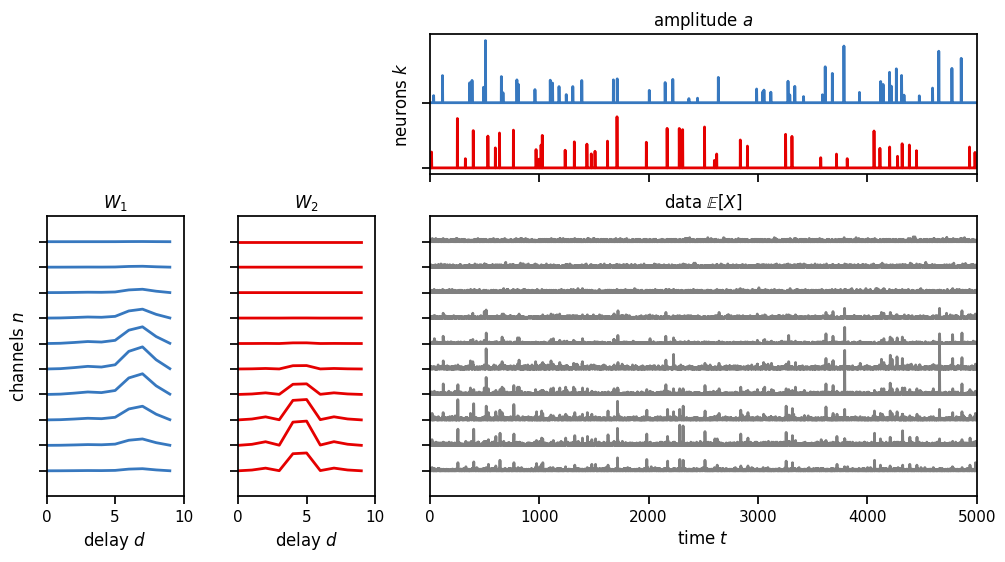

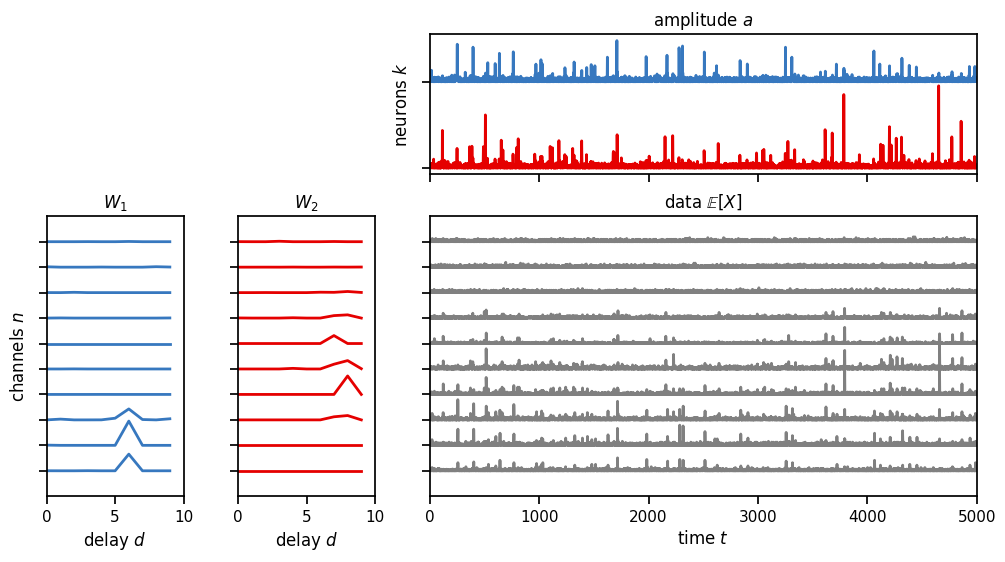

In [ ]:
T = 12000    # number of time samples
N = 1      # number of channels
D = 10    # duration of a spike (in samples)
K = 2      # neurons
true_w, true_a, true_b, X = generate(T, N, D, K)
plot_model(true_w, true_a, X)
b_pred, a_pred, w_pred, lps = em(X,K,D, n_iter=1000)
plot_model(w_pred, a_pred, X)
print(lps[-1])

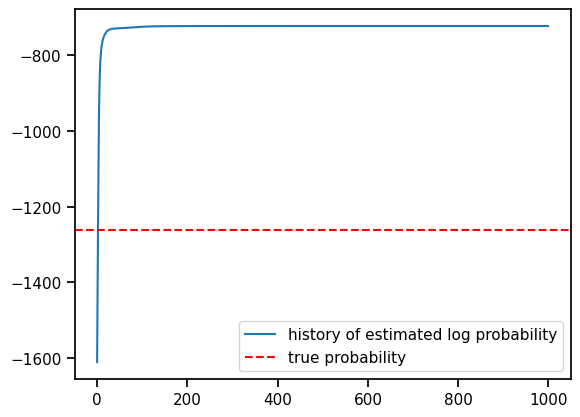

In [ ]:
plt.plot(lps, label='history of estimated log probability')
plt.axhline(y=log_probability(X, true_a, true_b, true_w), color='r', linestyle='--', label='true probability')
plt.legend()
plt.show()